In [1]:
!pip install pystan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.9 MB 7.7 MB/s 
     |████████████████████████████████| 69 kB 10.6 MB/s 
     |████████████████████████████████| 179 kB 77.9 MB/s 
     |████████████████████████████████| 45 kB 4.2 MB/s 
  Attempting uninstall: holidays
    Found existing installation: holidays 0.10.5.2
    Uninstalling holidays-0.10.5.2:
      Successfully uninstalled holidays-0.10.5.2
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 1.0.1 which is incompatible.


<h1>Cài đặt thư viện

Đầu tiên, ta thêm thư viện pandas, numpy và Prophet. 

In [3]:
import pandas as pd
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

Thêm thư viện tắt thông báo

In [4]:
import warnings
warnings.simplefilter('ignore')

Thêm thư viện đọc dữ liệu của Google Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

<h1>Đọc dữ liệu</h1>
Đầu vào của Prophet luôn là một tập dữ liệu với hai thuộc tính là ds và y. trong đó, ds có định dạng ngày, đánh dấu mốc thời gian. Và cột y đại diện cho giá trị định lượng, đại diện cho phép đo mà ta dự đoán.

In [7]:
train_ETH = pd.read_csv("/content/drive/My Drive/Năm 3/Làm nhóm HK2 2021 - 2022/Cá nhân/More/SF/Dataset/Data/7_3/eth/ethereum_train_7_3.csv", parse_dates=True, index_col=0)
train_ETH.head(5)

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2020-06-01,0.23180,0.24981,0.23085,0.24797,11970598,USD
2020-06-02,0.24801,0.25321,0.22795,0.23794,12686011,USD
2020-06-03,0.23790,0.24476,0.23384,0.24452,8151002,USD
2020-06-04,0.24453,0.24641,0.23668,0.24337,8749785,USD
2020-06-05,0.24337,0.24750,0.23970,0.24023,7754761,USD


In [8]:
train = train_ETH[["Open"]]
train.head(5)

,Open
Date,
2020-06-01,0.23180
2020-06-02,0.24801
2020-06-03,0.23790
2020-06-04,0.24453
2020-06-05,0.24337


In [9]:
train = train.reset_index(level=0)
train.columns = ['ds','y']
train.head(5)

,ds,y
0,2020-06-01,0.23180
1,2020-06-02,0.24801
2,2020-06-03,0.23790
3,2020-06-04,0.24453
4,2020-06-05,0.24337


In [10]:
test_ETH = pd.read_csv("/content/drive/My Drive/Năm 3/Làm nhóm HK2 2021 - 2022/Cá nhân/More/SF/Dataset/Data/7_3/eth/ethereum_test_7_3.csv", parse_dates=True, index_col=0)
test_ETH.head(5)

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2021-10-26,4.21992,4.29198,4.09819,4.12951,559294,USD
2021-10-27,4.13006,4.29961,3.91406,3.92193,1068620,USD
2021-10-28,3.92154,4.28980,3.89633,4.28490,865802,USD
2021-10-29,4.28490,4.45830,4.26821,4.41370,781573,USD
2021-10-30,4.41370,4.42841,4.25024,4.32065,494872,USD


In [11]:
test = test_ETH[["Open"]]
test.head(5)

,Open
Date,
2021-10-26,4.21992
2021-10-27,4.13006
2021-10-28,3.92154
2021-10-29,4.28490
2021-10-30,4.41370


In [12]:
test = test.reset_index(level=0)
test.columns = ['ds','y']
test.tail(5)

,ds,y
214,2022-05-28,1.72467
215,2022-05-29,1.79225
216,2022-05-30,1.81356
217,2022-05-31,1.99846
218,2022-06-01,1.94181


In [13]:
df = pd.concat([train, test],    # Combine vertically
                          ignore_index = True,
                          sort = False)
df.head(5)    

,ds,y
0,2020-06-01,0.23180
1,2020-06-02,0.24801
2,2020-06-03,0.23790
3,2020-06-04,0.24453
4,2020-06-05,0.24337


In [14]:
df.tail(5)    

,ds,y
726,2022-05-28,1.72467
727,2022-05-29,1.79225
728,2022-05-30,1.81356
729,2022-05-31,1.99846
730,2022-06-01,1.94181


<h1>Trực quan hóa dữ liệu

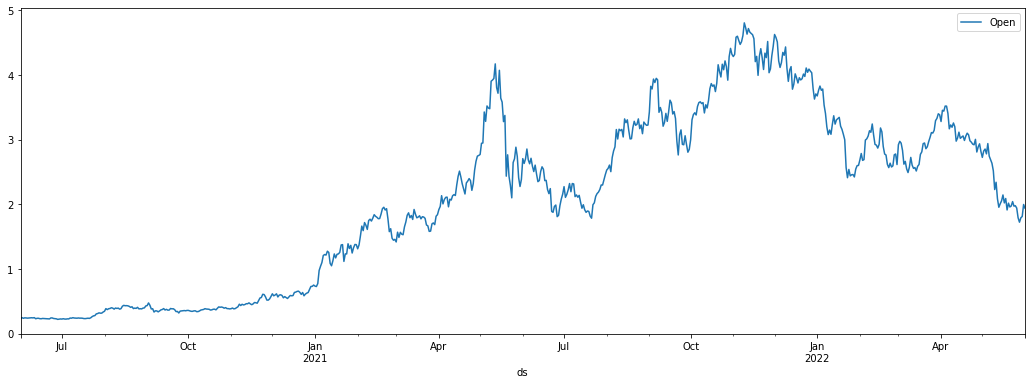

In [15]:
df.plot(x="ds", y='y',figsize=(18,6), label="Open")

<li>Ta xây dựng mô hình thông qua hàm Prophet()

In [16]:
interrupt = len(train)
interrupt

512

In [17]:
# Check size
print(train.shape)  
print(test.shape)  

(512, 2)
(219, 2)


In [18]:
future = df.copy()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


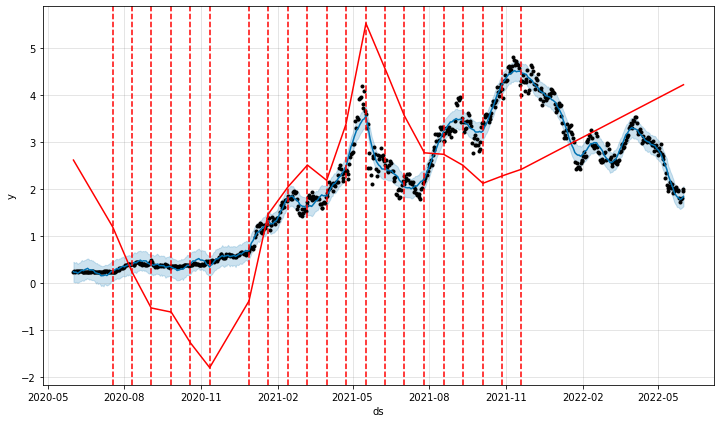

In [19]:
m = Prophet(changepoint_prior_scale=.99)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

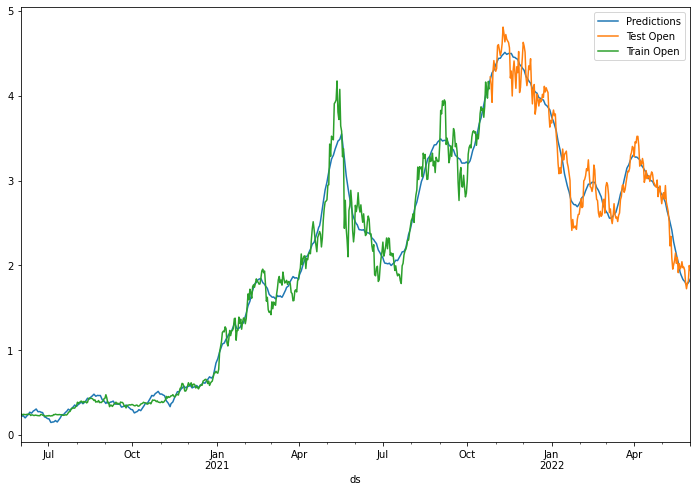

In [20]:
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8))
test.plot(x='ds',y='y',label='Test Open',legend=True,ax=ax)
train.plot(x='ds',y='y',label='Train Open',legend=True,ax=ax)
#,xlim=((datetime.strptime(current_time, '%Y-%m-%d') - timedelta(days = 30)).strftime("%Y-%m-%d"),current_time)

In [21]:
mae = mean_absolute_error(test.y, forecast[interrupt:].yhat)
mape = mean_absolute_percentage_error(test.y, forecast[interrupt:].yhat)
mse = mean_squared_error(test.y, forecast[interrupt:].yhat)
rmse = np.sqrt(mse)
r2 = r2_score(test.y, forecast[interrupt:].yhat)
# print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
# print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAPE: 4.22%
RMSE: 0.16
R2: 0.96
